# AQT Optimizations with Cirq

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/aqt/aqt_css.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/aqt/aqt_css.ipynb)

Below is a brief tutorial on Superstaq optimizations for the Advanced Quantum Testbed (AQT), a superconducting transmon quantum computing testbed at Lawrence Berkeley National Laboratory. For more information on AQT, visit their website [here](https://www.sandia.gov/quantum/quantum-information-sciences/projects/qscout/).

## Imports and API Token

This example tutorial notebook uses `cirq-superstaq`, our Superstaq client for Cirq; you can try it out by running `pip install cirq-superstaq`. To generate the plots, you'll also need a local installation of `qtrl`, the control software suite for the Quantum Nanoelectronics Laboratory (QNL) at the University of California, Berkeley.

In [2]:
try:
    import cirq
    import cirq_superstaq as css
except ImportError:
    print("Installing cirq-superstaq...")
    %pip install -q cirq-superstaq[examples]
    print("Installed cirq-superstaq. Please restart the kernel to import the packages.")

import numpy as np

# Prevent line wrapping in output cells (so longer circuits remain on one line)
import IPython

IPython.display.display(
    IPython.display.HTML("<style>div.output_area pre {white-space: pre;}</style>")
)

To interface Superstaq via Cirq, we must first instantiate a service provider in `cirq-superstaq` with `Service()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `css.Service()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_css.html#Set-up-access-to-Superstaq%E2%80%99s-API)) 

In [3]:
# Instantiate a Superstaq service
service = css.Service()

## Configuration

Superstaq's compilation endpoint for AQT is deeply integrated with the `qtrl` control software suite. We use your `qtrl` configs to determine what gates and qubits are available to the compiler, and to generate pulse sequences (`qtrl.sequencer.Sequence` objects) using the provided calibrations.

You can upload your YAML configuration files directly to Superstaq, or download previously-uploaded configs from the server:

In [4]:
# Download and save existing configs from the server (use `overwrite=True` to overwrite existing files, otherwise an error will be thrown if either file already exists locally)
service.aqt_download_configs("tmp-pulses.yaml", "tmp-variables.yaml", overwrite=True)

# Upload new configs to the server
service.aqt_upload_configs("tmp-pulses.yaml", "tmp-variables.yaml")

Pulses configuration saved to tmp-pulses.yaml.
Variables configuration saved to tmp-variables.yaml.


'Your AQT configuration has been updated'

You can also pass `qtrl.managers.PulseManager` and `qtrl.managers.VariableManager` objects directly to `aqt_upload_configs()`, in place of file paths. After uploading your configs, they will be saved to your account and used whenever you use Superstaq's compiler for AQT.

## Single circuit compilation

Let's start by creating an example `cirq.Circuit` that we will compile and optimize for the AQT.
As an initial example, we can construct a four-qubit circuit and pass it to Superstaq:

In [5]:
# Create a four-qubit uniform superposition
q0, q1, q2, q3, q4, q5, q6, q7 = cirq.LineQubit.range(8)
circuit1 = cirq.Circuit(cirq.H.on_each(q0, q1, q2, q3))

# Draw the input circuit
print(circuit1)

0: ───H───

1: ───H───

2: ───H───

3: ───H───


We will now compile the circuit generated above to the AQT's hardware. The primary method for interfacing Superstaq's AQT toolchain is the `aqt_compile` endpoint:

In [6]:
# Compile for AQT
compiler_output = service.aqt_compile(circuit1)

# Call circuit from the compiler output to get the corresponding output circuit
print(compiler_output.circuit)

4: ───Rz(0.5π)───Rx(0.5π)───Rz(0.5π)───

5: ───Rz(0.5π)───Rx(0.5π)───Rz(0.5π)───

6: ───Rz(0.5π)───Rx(0.5π)───Rz(0.5π)───

7: ───Rz(0.5π)───Rx(0.5π)───Rz(0.5π)───


The resulting output contains the same circuit compiled to AQT's native operations. Note that the original circuit was mapped to the active qubits on this device (by default qubits 4 through 8), and optimized to exploit AQT's use of virtual Z rotations (as opposed to the canonical Hadamard decomposition requiring two Rx(π/2) and a single Rz(π/2) gate, as described in [1]).

If you have `qtrl` installed locally and have already uploaded configs to Superstaq, the output will also contain the corresponding pulse sequence (an instance of `qtrl.sequencer.Sequence`):

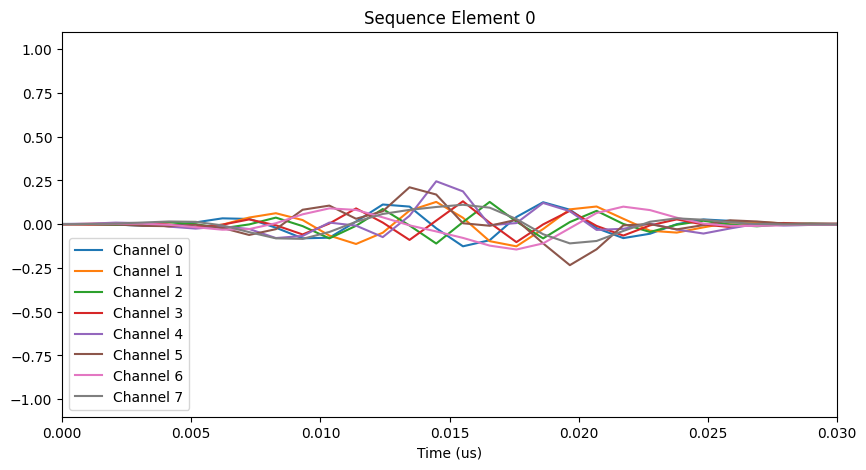

In [7]:
# Draw the corresponding pulse sequence (requires a local `qtrl` configuration, and config files uploaded to Superstaq)
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

By default, the sequences generated by `aqt_compile` assume the Keysight control hardware configuration. You can instead compile for Zurich control hardware using `target="aqt_zurich_qpu"`, as shown below (notice the visible change in sample rate). You can also pass `target="aqt_keysight_qpu"` to indicate keysight control hardware explicitly.

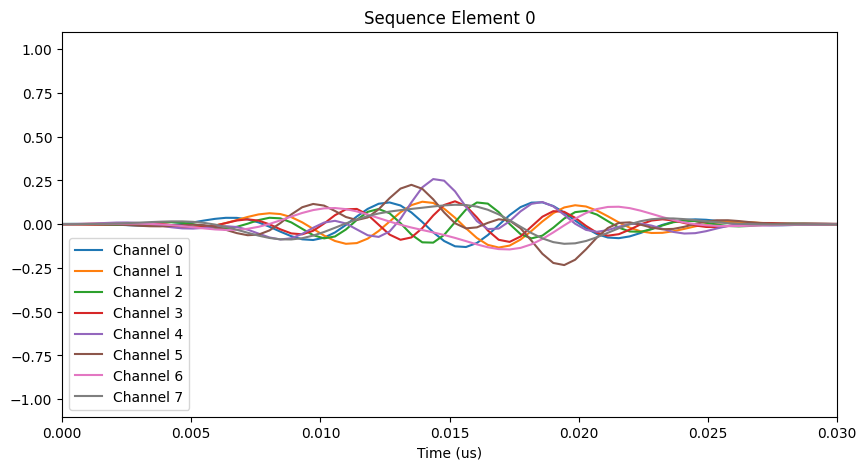

In [8]:
# Compile for AQT Zurich
compiler_output = service.aqt_compile(circuit1, target="aqt_zurich_qpu")

# Draw the corresponding pulse sequence:
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

## Multiple circuit compilation

Superstaq's compilation endpoints also allow for the submission of multiple circuits. To illustrate this, let's create a second example circuit containing a single SWAP gate:

In [9]:
# Construct a SWAP circuit
circuit2 = cirq.Circuit(cirq.SWAP(q0, q1))

# Draw the circuit
print(circuit2)

0: ───×───
      │
1: ───×───


When a list of circuits is passed to `aqt_compile`, each will be individually compiled and then merged into a single `qtrl` pulse sequence object. The resulting list of compiled circuits can be accessed via the compiler output's `.circuits` attribute:

In [10]:
# Send both example circuits to Superstaq as a list
compiler_output = service.aqt_compile([circuit1, circuit2])

# Draw the compiled circuits
print(
    f"""Total circuits compiled: {len(compiler_output.circuits)}

Compiled circuit 1:
{compiler_output.circuits[0]}


Compiled circuit 2:
{compiler_output.circuits[1]}
"""
)

Total circuits compiled: 2

Compiled circuit 1:
4: ───Rz(0.5π)───Rx(0.5π)───Rz(0.5π)───

5: ───Rz(0.5π)───Rx(0.5π)───Rz(0.5π)───

6: ───Rz(0.5π)───Rx(0.5π)───Rz(0.5π)───

7: ───Rz(0.5π)───Rx(0.5π)───Rz(0.5π)───


Compiled circuit 2:
4: ───Rx(0.5π)───@───Rx(0.5π)───@───Rx(0.5π)───@───
                 │              │              │
5: ───Rx(0.5π)───@───Rx(0.5π)───@───Rx(0.5π)───@───



Notice that the compiled SWAP circuit uses the optimized SWAP decomposition outlined in [1], which reduces circuit depth by parallelizing the outer single-qubit gates. This parallelization is also apparent in the corresponding pulse sequence (if available). When compiling multiple circuits, each pulse sequence can be accessed via the corresponding `element` of the combined `qtrl.sequencer.Sequence` object (assigned consecutively):

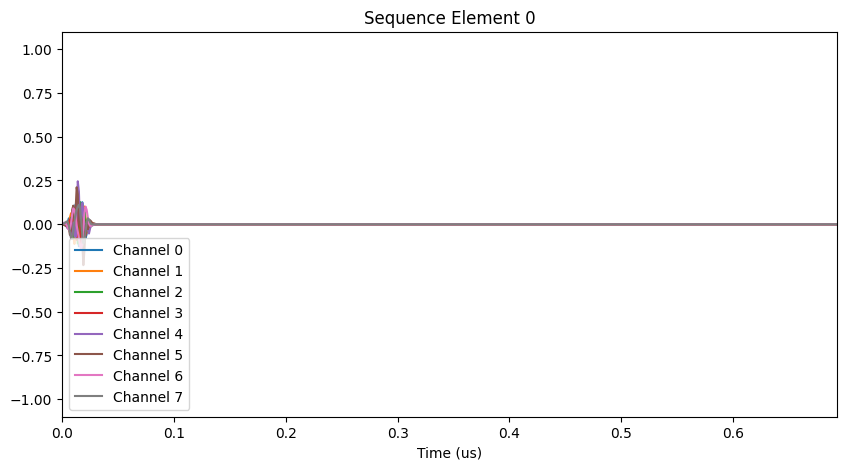

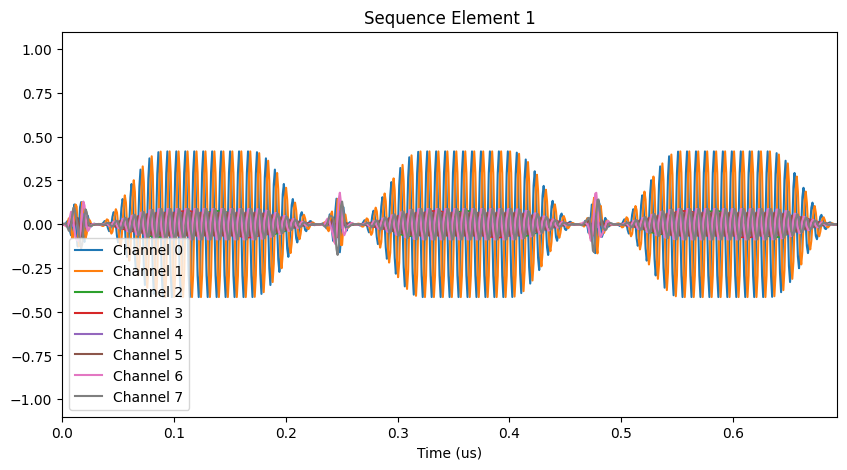

In [11]:
# Draw the corresponding pulse sequences (requires a local `qtrl` configuration, and config files uploaded to Superstaq):
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)  # pulse sequence corresponding to circuit1
    compiler_output.seq.plot(element=1)  # pulse sequence corresponding to circuit2

## Custom operations

Superstaq's compilation toolchain is designed to support a flexible set of native hardware operations. It will automatically recognize various AQT-specific hardware operations if corresponding calibrations exist in your pulse configuration, such as CS/CSD, iToffoli, or optimized calibrations for parallel CZ/CS operations. Custom gates defined in `cirq-superstaq` are provided for those operations which do not exist in Cirq itself.

### iToffoli

The AQT iToffoli operation is defined as an open-control Toffoli gate with an additional CPhase(π/2) acting on the two control qubits (see [2]). You can instantiate it using the `css.AQTITOFFOLI` (or `css.AQTICCX`) custom gate:

In [12]:
# Instantiate a circuit containing an AQT iToffoli targetting qubit 5 and controlled by qubits 4 and 6
circuit = cirq.Circuit(
    cirq.H(q4),
    css.AQTICCX(q4, q6, q5),
)

# Draw the circuit
print(circuit)

4: ───H───(0)───
          │
5: ───────iX────
          │
6: ───────(0)───


If a corresponding callibration is provided in your pulse configuration (under the key `"TOF"`), `aqt_compile` will recognize this operation instead of decomposing it into the standard gateset:

4: ───Rz(0.5π)───Rx(0.5π)───Rz(0.5π)───(0)───
                                       │
5: ────────────────────────────────────iX────
                                       │
6: ────────────────────────────────────(0)───


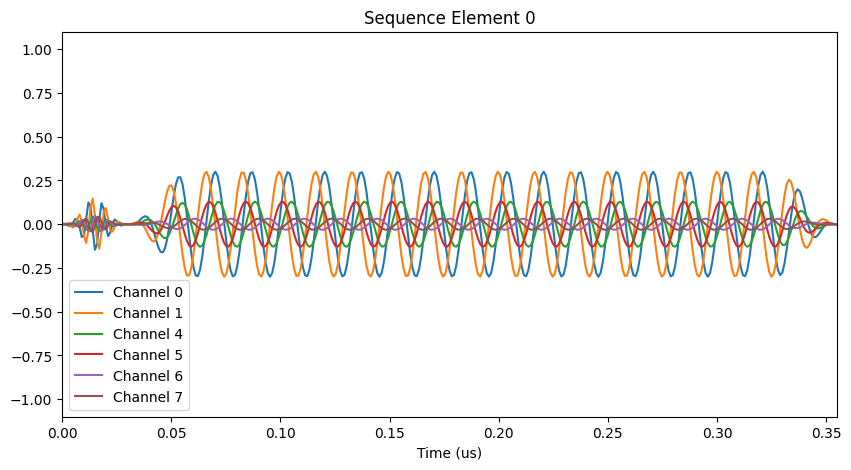

In [13]:
# Compile for AQT
compiler_output = service.aqt_compile(circuit)

# Draw the compiled circuit
print(compiler_output.circuit)

# ...and the corresponding pulse sequence
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

### CS and CSD

The `aqt_compile` endpoint also has out-of-the-box support for controlled partial-rotation CPhase(±π/2) (i.e. "CS" and "CSD") gates. These can be invoked directly via `cirq.CZ**±0.5`, as in the following example. In this example we also make use of the custom `css.Barrier` gate in order to prevent the compiler from merging or rescheduling the gates we're trying to illustrate. Note the smaller pulse amplitudes and durations of the CS and CSD operations relative to the CZs in the resulting pulse sequence:

4: ───@───────────│───@─────────────────────────
      │           │   │
5: ───@───@───────│───@^-0.5───@────────────────
          │       │            │
6: ───────@───@───│────────────@^0.5───@────────
              │   │                    │
7: ───────────@───│────────────────────@^-0.5───


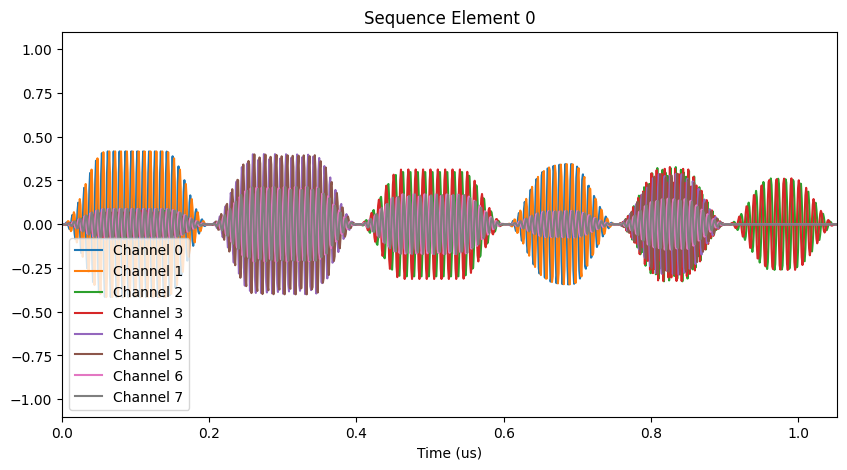

In [14]:
# Instantiate a circuit containing CZ, CS, and CSD operations
circuit = cirq.Circuit(
    cirq.CZ(q0, q1),
    cirq.CZ(q1, q2),
    cirq.CZ(q2, q3),
    # Prevent optimizations or parallelization of gates across this barrier:
    css.barrier(q0, q1, q2, q3),
    cirq.CZ(q0, q1) ** -0.5,
    cirq.CZ(q1, q2) ** 0.5,
    cirq.CZ(q2, q3) ** -0.5,
)

# Compile for AQT
compiler_output = service.aqt_compile(circuit)

# Draw the compiled circuit
print(compiler_output.circuit)

# ...and the corresponding pulse sequence
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

These gates will also be inferred automatically when decomposing arbitrary circuits. For example, as described in [1], the ZZ-SWAP operation (also available as a custom gate in `cirq-superstaq`) can for some angles be implemented with two CZs and a CS or CSD operation, instead of three CZs. Similarly, any controlled-rotation can be implemented using a pair of CS or CSD gates, instead of two CZs:

In [15]:
# The ZZ-SWAP(θ) gate requires 3 CZ gates for |θ| < π/4
circuit1 = cirq.Circuit(
    css.ZZSwapGate(np.pi / 8).on(q5, q6),
)

# For π/4 <= |θ| <= 3π/4, the ZZ-SWAP(θ) gate can be implemented using two CZs and a CS (or CSD)
circuit2 = cirq.Circuit(
    css.ZZSwapGate(np.pi / 3).on(q5, q6),
)

# Controlled-SU(2) gates can always be implemented using two CS or CSD gates
circuit3 = cirq.Circuit(cirq.ry(-2 * np.pi / 3).on(q6).controlled_by(q5))

# Draw the input circuits
print(
    f"""
Circuit 1:
{circuit1}

Circuit 2:
{circuit2}

Circuit 3:
{circuit3}
"""
)


Circuit 1:
5: ───ZZSwap(0.125π)───
      │
6: ───ZZSwap(0.125π)───

Circuit 2:
5: ───ZZSwap(0.333π)───
      │
6: ───ZZSwap(0.333π)───

Circuit 3:
5: ───@─────────────
      │
6: ───Ry(-0.667π)───



When these operations are compiled with `aqt_compile`, Superstaq will automatically recognize the cases in employing CS or CSD gates results in a more efficient decomposition:


Circuit 1 (compiled):
5: ───Rx(0.5π)───@───Rx(0.5π)───@───Rz(-0.125π)───Rx(0.5π)───@───Rx(0.5π)───
                 │              │                            │
6: ──────────────@───Rx(0.5π)───@─────────────────Rx(0.5π)───@──────────────


Circuit 2 (compiled):
5: ───Rz(-1.5π)───Rx(0.5π)───Rz(0.696π)───Rx(0.5π)───Rz(0.5π)───@───Rx(0.5π)───@───────────────Rx(0.5π)───@───────Rz(1.25π)─────────────────────────────────────────────────
                                                                │              │                          │
6: ───────────────Rx(0.5π)──────────────────────────────────────@───Rx(0.5π)───@───Rz(0.75π)───Rx(0.5π)───@^0.5───Rz(1.75π)───Rx(0.5π)───Rz(0.696π)───Rx(0.5π)───Rz(0.5π)───


Circuit 3 (compiled):
5: ───Rz(1.8π)───Rx(0.5π)───Rz(0.696π)────Rx(0.5π)───Rz(0.25π)───@───────Rx(0.5π)───@───────Rz(-1.75π)───Rx(0.5π)───Rz(0.696π)───Rx(0.5π)───Rz(-0.797π)───
                                                                 │                  │
6: ───Rz(π)──────

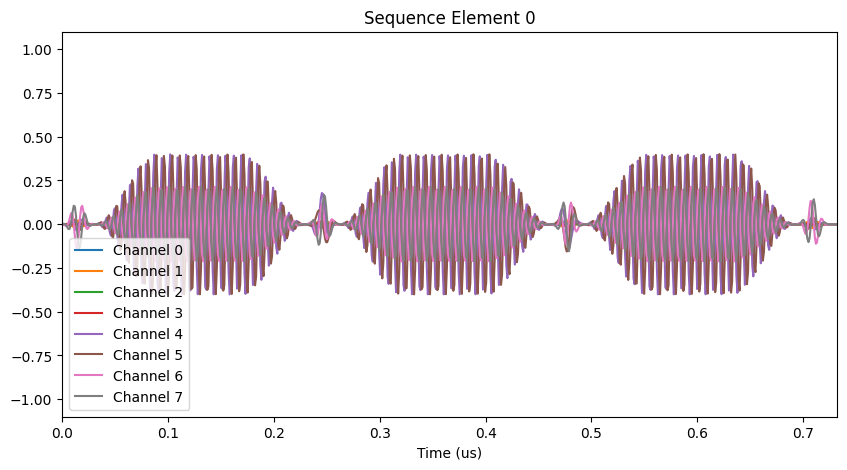

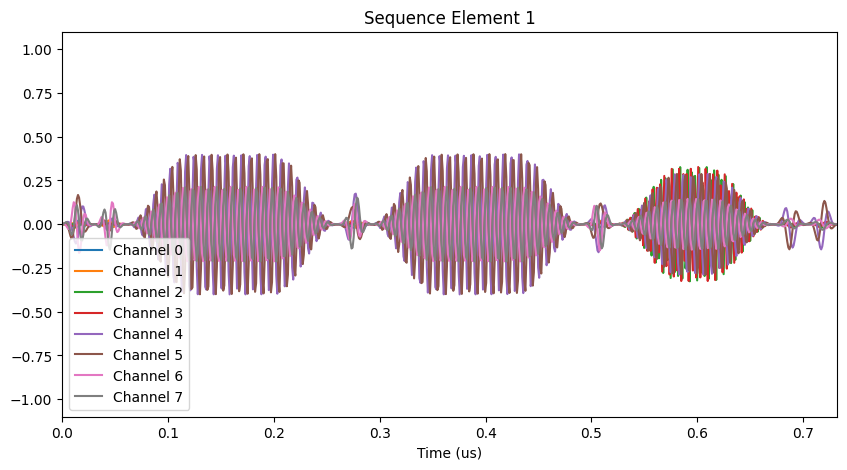

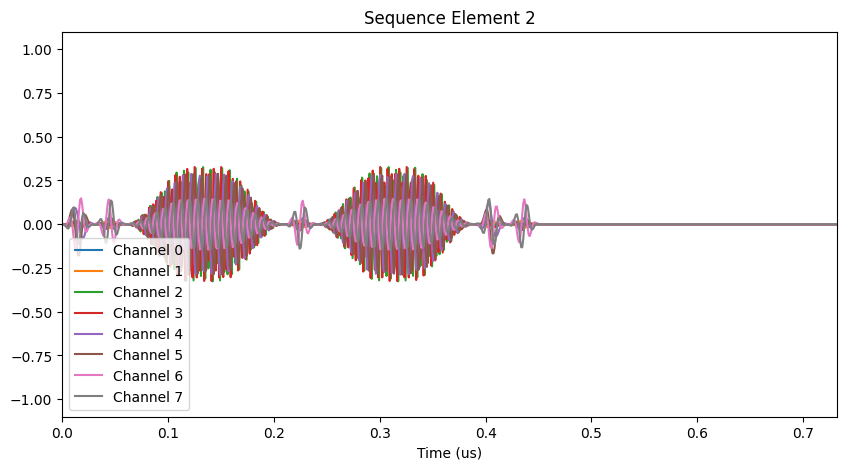

In [16]:
# Compile for AQT
compiler_output = service.aqt_compile([circuit1, circuit2, circuit3])

# Draw the compiled circuits
print(
    f"""
Circuit 1 (compiled):
{compiler_output.circuits[0]}


Circuit 2 (compiled):
{compiler_output.circuits[1]}


Circuit 3 (compiled):
{compiler_output.circuits[2]}
"""
)

# ...and the corresponding pulse sequences
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)
    compiler_output.seq.plot(element=1)
    compiler_output.seq.plot(element=2)

### Simultaneous CZs and CSDs

The `aqt_compile` endpoint also supports optimized callibrations for parallel CZ and CS/CSD operations [1]. These are inferred automatically by the compiler, or can be invoked directly using `cirq-superstaq`'s custom `ParallelGates` operation:


Input circuit:
4: ───@₁───@₁────────│───────@───────────@────────
      │    │         │       │           │
5: ───@₁───@₁^-0.5───│───@───@───@───────@^-0.5───
      │    │         │   │       │
6: ───@₂───@₂────────│───@───@───@^0.5───@────────
      │    │         │       │           │
7: ───@₂───@₂^-0.5───│───────@───────────@^-0.5───


Compiled circuit:
4: ───@₁───@₁────────│───────@₁───────────@₁────────
      │    │         │       │            │
5: ───@₁───@₁^-0.5───│───@───@₁───@───────@₁^-0.5───
      │    │         │   │   │    │       │
6: ───@₂───@₂────────│───@───@₂───@^0.5───@₂────────
      │    │         │       │            │
7: ───@₂───@₂^-0.5───│───────@₂───────────@₂^-0.5───



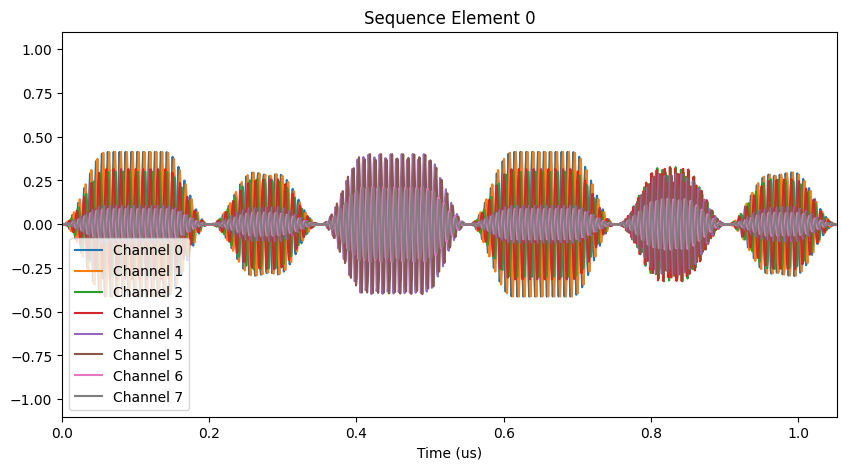

In [17]:
# Directly instantiated parallel operations:
circuit = cirq.Circuit(
    css.ParallelGates(cirq.CZ, cirq.CZ).on(q4, q5, q6, q7),
    css.ParallelGates(cirq.CZ**-0.5, cirq.CZ**-0.5).on(q4, q5, q6, q7),
)

circuit += css.barrier(q4, q5, q6, q7)

# Implicitly instantiated parallel operations:
circuit += (
    cirq.CZ(q5, q6),
    cirq.CZ(q4, q5),
    cirq.CZ(q6, q7),
    cirq.CZ(q5, q6) ** 0.5,
    cirq.CZ(q4, q5) ** -0.5,
    cirq.CZ(q6, q7) ** -0.5,
)

# Compile for AQT
compiler_output = service.aqt_compile(circuit)

# Draw the initial and compiled circuits
print(
    f"""
Input circuit:
{circuit}


Compiled circuit:
{compiler_output.circuit}
"""
)

# ...and the corresponding pulse sequence
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

When compiling arbitrary circuits, `aqt_compile` will also attempt to align and merge any gates resulting from the decomposition and optimization of the input circuit if an optimized parallel calibration exists. As an example, we can place two of the ZZ-SWAP gates used in the previous example on adjacent pairs of qubits:

In [18]:
# Build a circuit with two ZZ-SWAP operations in parallel
circuit = cirq.Circuit(
    css.ZZSwapGate(np.pi / 3).on(q4, q5),
    css.ZZSwapGate(np.pi / 3).on(q6, q7),
)

# Draw the circuit
print(circuit)

4: ───ZZSwap(0.333π)───
      │
5: ───ZZSwap(0.333π)───

6: ───ZZSwap(0.333π)───
      │
7: ───ZZSwap(0.333π)───


When we compile this circuit with `aqt_compile`, the corresponding CZ and CSD operations of each operation will be merged into `css.ParallelGates` operations in the compiled circuit, and the corresponding optimized calibration will be used in the resulting pulse sequence:

4: ───Rz(1.5π)───Rx(0.5π)───Rz(0.696π)───Rx(0.5π)───Rz(-0.5π)───@₁───Rx(0.5π)───@₁───────────────Rx(0.5π)───@₁────────Rz(0.75π)─────────────────────────────────────────────────
                                                                │               │                           │
5: ──────────────Rx(0.5π)───────────────────────────────────────@₁───Rx(0.5π)───@₁───Rz(0.75π)───Rx(0.5π)───@₁^-0.5───Rz(1.25π)───Rx(0.5π)───Rz(0.304π)───Rx(0.5π)───Rz(0.5π)───
                                                                │               │                           │
6: ───Rz(1.5π)───Rx(0.5π)───Rz(0.696π)───Rx(0.5π)───Rz(-0.5π)───@₂───Rx(0.5π)───@₂───────────────Rx(0.5π)───@₂────────Rz(0.75π)─────────────────────────────────────────────────
                                                                │               │                           │
7: ──────────────Rx(0.5π)───────────────────────────────────────@₂───Rx(0.5π)───@₂───Rz(0.75π)───Rx(0.5π)───@₂^-0.5───Rz(1.25π)───Rx(0.5π)─

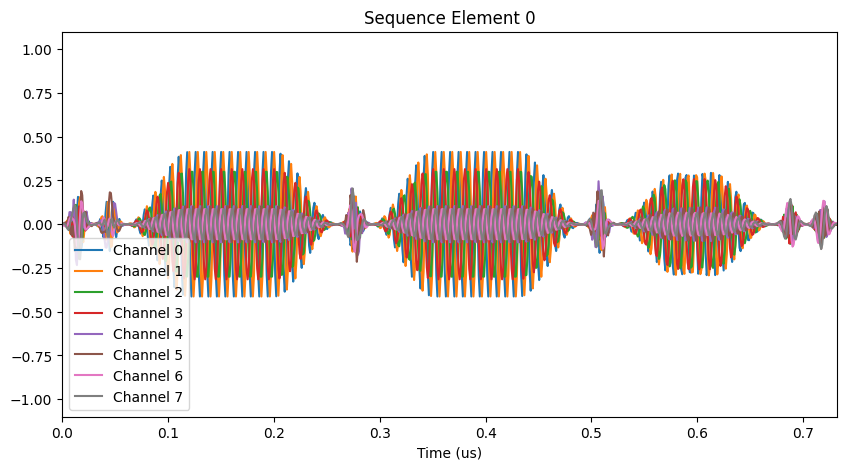

In [19]:
# Compile for AQT
compiler_output = service.aqt_compile(circuit)

# Draw the compiled circuit
print(compiler_output.circuit)

# ...and the corresponding pulse sequence
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

### Bring Your Own

In addition to the predefined gates described above, you can assign arbitrary gate definitions to pulse sequence `aqt_compile` via its `gate_defs=` argument. To demonstrate this functionality, let's start with a pair of controlled rotation gates (which we've already seen can be implemented with two CS or CSD operations):

In [20]:
# Construct a circuit with a pair of controlled-X rotations
circuit = cirq.Circuit(
    cirq.rx(2 * np.pi / 3).on(q1).controlled_by(q0),
    cirq.rx(2 * np.pi / 3).on(q3).controlled_by(q2),
)

# Draw the input circuit
print(circuit)

0: ───@────────────
      │
1: ───Rx(0.667π)───

2: ───@────────────
      │
3: ───Rx(0.667π)───


Now, say we had \*intended\* to tune up a couple of CSD gates, but our calibrations weren't perfect and so in practice these operations are under-rotated a bit. We can use `gate_defs` to tell `aqt_compile` the \*actual\* physical gates implemented by the calibrations in our pulse configuration, which will then be used when compiling the provided circuit. The definitions in `gate_defs` can be `cirq.Gate` objects or arbitrary unitary matrices:

In [21]:
# Define the actual, under-rotated physical gates implemented by the CSD calibrations in our pulse configuration, using `cirq.Gate` objects
gate_defs = {
    "CSD/C5T4": cirq.CZ**-0.45,  # Gate implemented by our "CSD" calibration for qubits 4 and 5
    "CSD/C7T6": cirq.CZ**-0.35,  # Gate implemented by our "CSD" calibration for qubits 6 and 7
}

When we pass `gate_defs` to `aqt_compile` alongside the input circuit, we see that it now uses the correct operations for each pair of qubits in the compiled circuit:

4: ───Rz(1.06π)────Rx(0.5π)───Rz(0.264π)───Rx(0.5π)───Rz(0.725π)────@─────────Rz(-1.5π)───Rx(0.5π)───Rz(0.559π)───Rx(0.5π)───Rz(0.5π)───@─────────Rz(-1.27π)───Rx(0.5π)───Rz(0.264π)───Rx(0.5π)───Rz(-0.056π)───
                                                                    │                                                                   │
5: ───Rz(0.5π)─────Rx(0.5π)───Rz(0.938π)────────────────────────────@^-0.45─────────────────────────────────────────────────────────────@^-0.45───Rz(0.845π)───Rx(0.5π)───Rz(0.5π)──────────────────────────────

6: ───Rz(-1.89π)───Rx(0.5π)───Rz(0.891π)───Rx(0.5π)───Rz(-0.325π)───@─────────Rz(-1.5π)───Rx(0.5π)───Rz(0.813π)───Rx(0.5π)───Rz(0.5π)───@─────────Rz(1.68π)────Rx(0.5π)───Rz(0.891π)───Rx(0.5π)───Rz(0.894π)────
                                                                    │                                                                   │
7: ───Rz(1.5π)─────Rx(0.5π)───Rz(0.612π)────────────────────────────@^-0.35─────────────────────

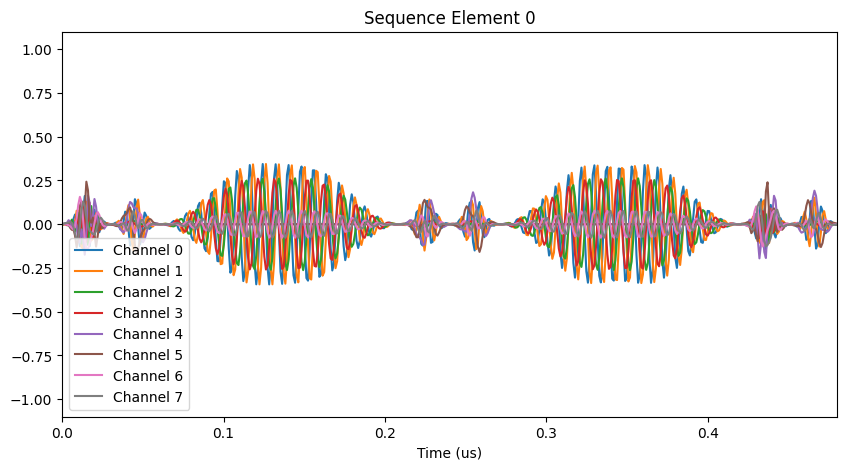

In [22]:
# Compile for AQT
compiler_output = service.aqt_compile(circuit, gate_defs=gate_defs)

# Draw the compiled circuit
print(compiler_output.circuit)

# ...and the corresponding pulse sequence
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

As a second example, let's assume both CSD calibrations now contain some extra single-qubit phase terms. This time we will pass the gate definitions as unitary matrices. For the purposes of this illustration, we will also override the CZ and CS calibrations to prevent the compiler from using them:

4: ───Rz(-1.79π)───Rx(0.5π)────────────────Rx(0.5π)───Rz(0.66π)─────CSD/C5T4[2]───Rz(1.65π)────Rx(0.5π)────────────────Rx(0.5π)───Rz(-0.486π)───CSD/C5T4[2]───Rz(1.29π)───Rx(0.5π)───Rz(π)────────Rx(0.5π)───Rz(0.291π)────
                                                                    │                                                                           │
5: ───Rz(-1.74π)───Rx(0.5π)───Rz(0.557π)───Rx(0.5π)───Rz(0.891π)────CSD/C5T4[1]───Rz(-1.08π)───Rx(0.5π)───Rz(0.441π)───Rx(0.5π)───Rz(0.131π)────CSD/C5T4[1]───Rz(1.43π)───Rx(0.5π)───Rz(0.322π)───Rx(0.5π)───Rz(-0.794π)───

6: ───Rz(-1.53π)───Rx(0.5π)────────────────Rx(0.5π)───Rz(-0.951π)───CSD/C7T6[2]───Rz(1.03π)────Rx(0.5π)────────────────Rx(0.5π)───Rz(0.292π)────CSD/C7T6[2]───Rz(1.32π)────────────────────────────────────────────────────
                                                                    │                                                                           │
7: ───Rz(-1.97π)───Rx(0.5π)───Rz(0.395π)───Rx(0

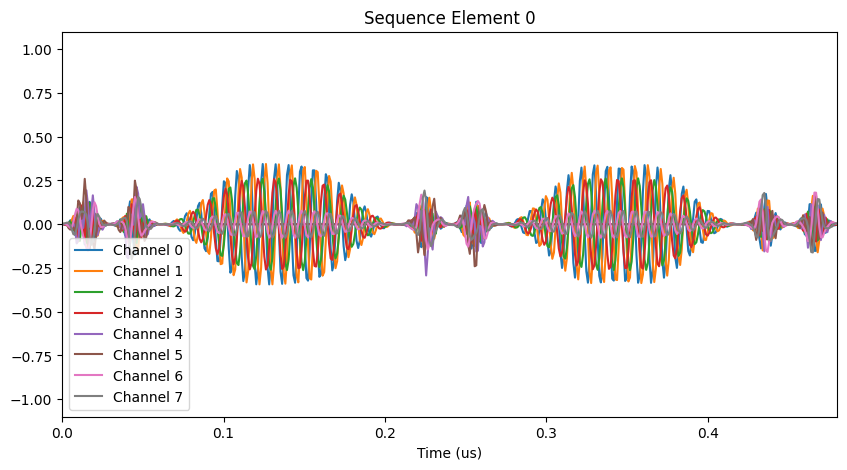

In [23]:
# Define the actual, under-rotated physical gates implemented by the CSD calibrations in our pulse configuration, using unitary matrices
gate_defs = {
    "CSD/C5T4": np.diag(
        [1.0, np.exp(0.1j), np.exp(-0.1j), np.exp(-0.45j * np.pi)]
    ),  # Gate implemented by our "CSD" calibration for qubits 4 and 5
    "CSD/C7T6": np.diag(
        [1.0, np.exp(0.1j), np.exp(-0.1j), np.exp(-0.35j * np.pi)]
    ),  # Gate implemented by our "CSD" calibration for qubits 6 and 7
    "CZ": None,  # Prevent compiler from using any of the "CZ" calibrations in our pulse config
    "CS": None,  # Prevent compiler from using any of the "CS" calibrations in our pulse config
}

# Compile for AQT
compiler_output = service.aqt_compile(circuit, gate_defs=gate_defs)

# Draw the compiled circuit
print(compiler_output.circuit)

# ...and the corresponding pulse sequence
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

## Equivalent circuit averaging (ECA)

Superstaq provides an additional second endpoint for equivalent circuit averaging (also introduced in [1]). Using the `num_eca_circuits` argument of `aqt_compile()`, a single input circuit can be compiled into a set of logically equivalent but physically distinct pulse sequences.

### Example: single-qubit gate decomposition

As a preliminary example, let's consider the decomposition of a single-qubit gate. Arbitrary SU(2) operations can be implemented on AQT using two Rx(π/2) pulses. Two such decompositions exist, which will be selected at random if `num_eca_circuits` is set:

In [24]:
# Randomly select an operation in SU(2)
matrix = cirq.testing.random_special_unitary(2, random_state=1234)

# Constuct a circuit containing just that single-qubit gate
circuit = cirq.Circuit(cirq.MatrixGate(matrix).on(q0))

# Use Superstaq to generate 5 logically-equivalent circuits for ECA
compiler_output = service.aqt_compile(circuit, num_eca_circuits=5, random_seed=1234)

# Draw the each compiled circuit
for compiled_circuit in compiler_output.circuits:
    print(compiled_circuit)
    print()

4: ───Rz(0.089π)───Rx(0.5π)───Rz(1.7π)───Rx(0.5π)───Rz(1.43π)───

4: ───Rz(0.089π)───Rx(0.5π)───Rz(1.7π)───Rx(0.5π)───Rz(1.43π)───

4: ───Rz(1.09π)───Rx(0.5π)───Rz(0.303π)───Rx(0.5π)───Rz(0.433π)───

4: ───Rz(1.09π)───Rx(0.5π)───Rz(0.303π)───Rx(0.5π)───Rz(0.433π)───

4: ───Rz(0.089π)───Rx(0.5π)───Rz(1.7π)───Rx(0.5π)───Rz(1.43π)───



We can also confirm that the corresponding pulse sequences are physically distinct:

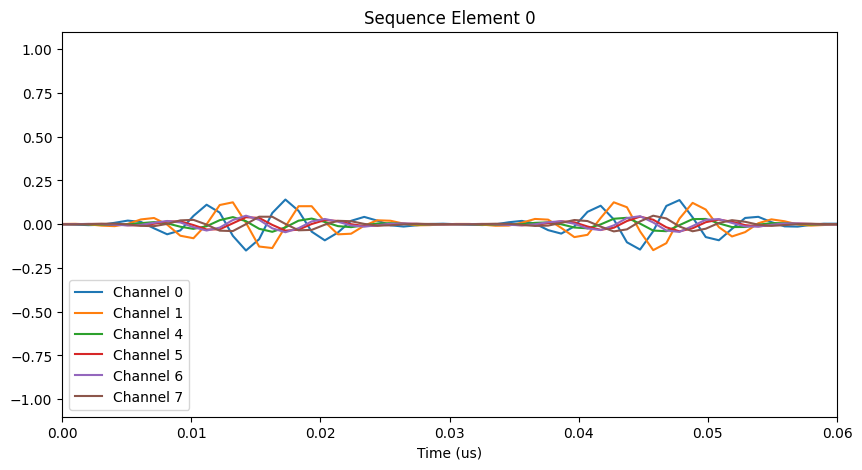

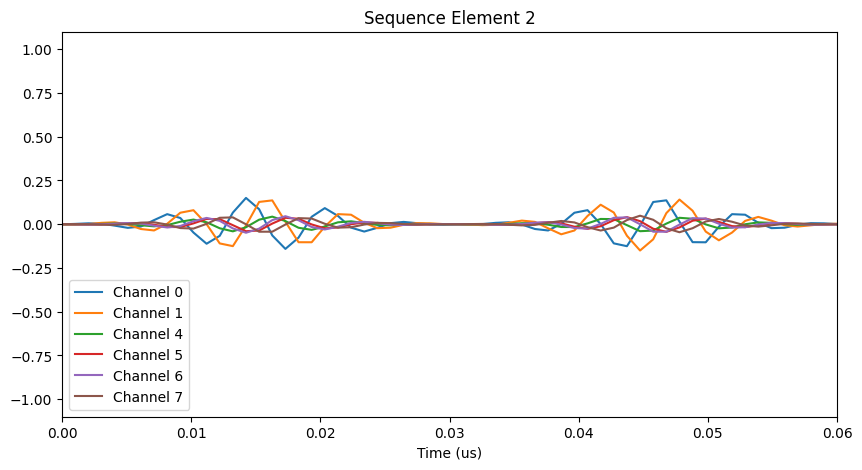

In [25]:
# Draw the two distinct pulse sequences
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)
    compiler_output.seq.plot(element=2)

### Example: ZZ-SWAP

For a more illuminating example, let's again consider the ZZ-SWAP gate used above (which allows for implementation using two CZs and a single CS operation). The compiled circuit returned in that example is far from unique; in fact there a great many physically distinct implementations it could have chosen. This is made apparent when compiling the circuit for ECA:

In [26]:
# Construct a circuit with a single one-qubit gate
circuit = cirq.Circuit(
    css.ZZSwapGate(1.23).on(q1, q2),
)

# Draw the input circuit
print("Input circuit:")
print(circuit)

# Use Superstaq to generate 5 equivalent circuits using ECA compilation
compiler_output = service.aqt_compile(circuit, num_eca_circuits=5, random_seed=1234)

# Print the equivalent circuits and pulse sequences
print("\n\nEquivalent compiled circuits:")
for i in range(5):
    print(compiler_output.circuits[i])
    print()
    print()

Input circuit:
1: ───ZZSwap(0.392π)───
      │
2: ───ZZSwap(0.392π)───


Equivalent compiled circuits:
5: ───Rz(-0.314π)─────────────────────────────────────────────────@───────Rx(0.5π)───@───────────────Rx(0.5π)───@───Rz(-1.5π)───Rx(0.5π)───Rz(0.27π)─────Rx(0.5π)───Rz(0.936π)───
                                                                  │                  │                          │
6: ───Rz(0.064π)────Rx(0.5π)───Rz(1.39π)───Rx(0.5π)───Rz(1.75π)───@^0.5───Rx(0.5π)───@───Rz(1.34π)───Rx(0.5π)───@───────────────Rx(0.5π)───Rz(-0.436π)───────────────────────────


5: ───Rz(1.75π)───Rx(0.5π)───Rz(1.61π)───Rx(0.5π)───Rz(1.75π)─────@───────Rx(0.5π)───@───Rz(0.657π)───Rx(0.5π)───@───Rz(π)──────Rx(0.5π)───Rz(0.25π)──────────────────────────
                                                                  │                  │                           │
6: ───Rz(1.34π)───Rx(0.5π)───────────────Rx(0.5π)───Rz(-0.165π)───@^0.5───Rx(0.5π)───@────────────────Rx(0.5π)───@───Rz(0.5π)───Rx(0.5π

We can see many differences between the compiled circuits above, such as whether the CS gate comes before or after the two CZ gates, which qubits the Rx(π/2) gates are applied to in each moment, and the virtual phases applied to each qubit between these operations. These all result in physical distinctions between the corresponding pulse sequences:

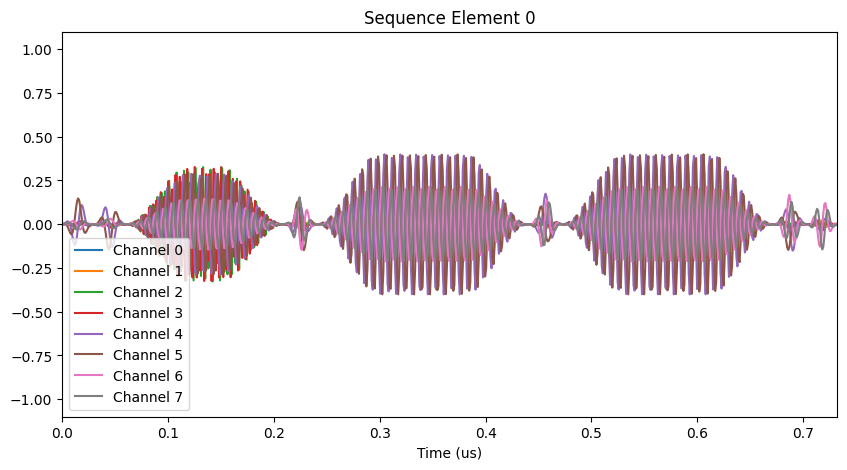

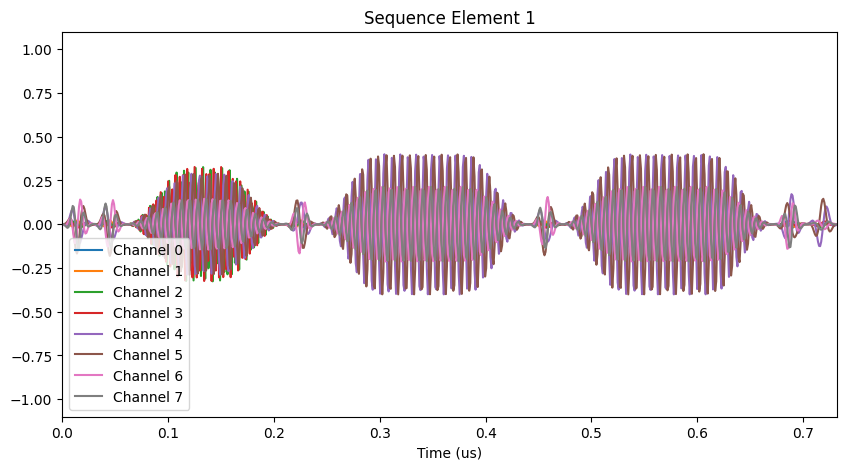

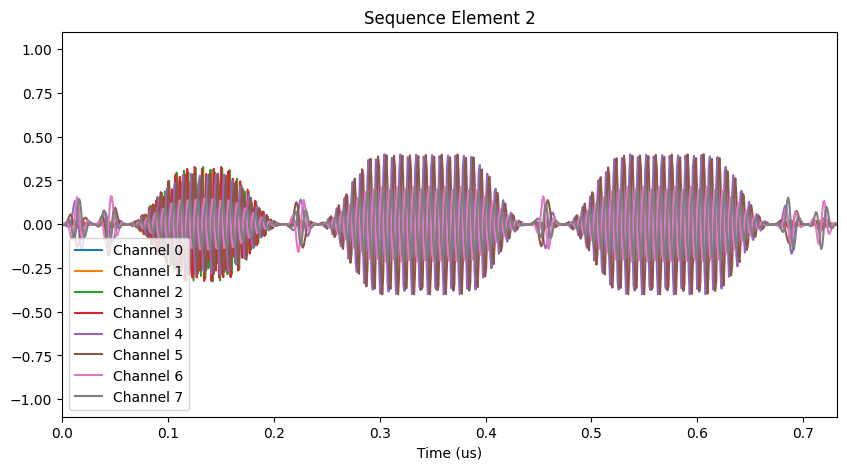

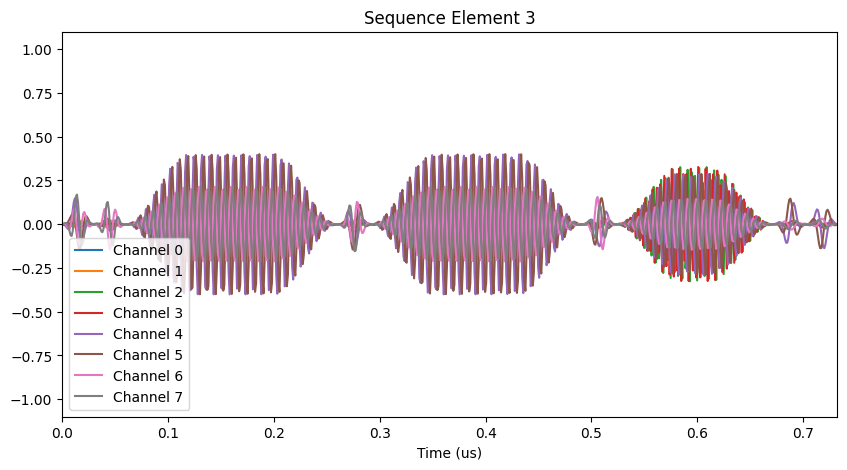

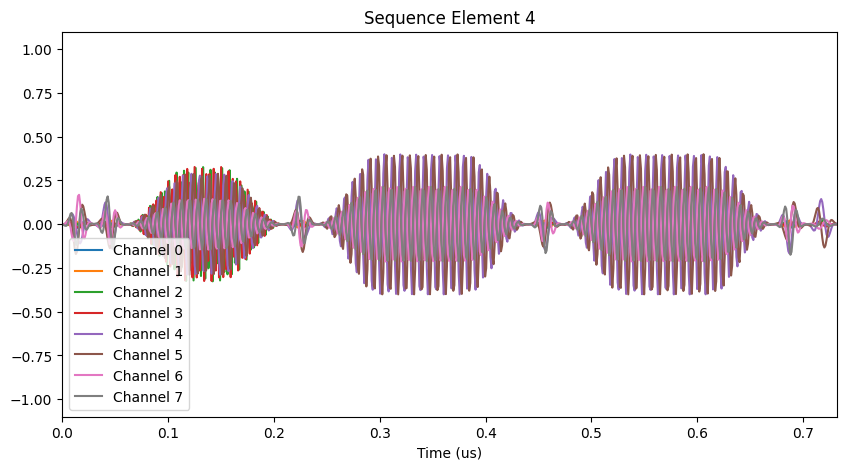

In [27]:
# Draw the two distinct pulse sequences
if compiler_output.seq is not None:
    for element in range(5):
        compiler_output.seq.plot(element=element)